In [13]:
# import kagglehub
#
# # Download latest version
# path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")
#
# print("Path to dataset files:", path)

100%|██████████| 1.47M/1.47M [00:01<00:00, 1.35MB/s]

Extracting files...
Path to dataset files: C:\Users\ngmin\.cache\kagglehub\datasets\dylanjcastillo\7k-books-with-metadata\versions\3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = 'C:\\Users\\ngmin\\.cache\kagglehub\datasets\\dylanjcastillo\\7k-books-with-metadata\\versions\\3'

In [4]:
books = pd.read_csv(f"{PATH}/books.csv")

In [5]:
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


### **1. Check missing values**

In [6]:
print("The shape of the data:", books.shape)

The shape of the data: (6810, 12)


In [7]:
books.isnull().sum().sort_values(ascending=False)

subtitle          4429
thumbnail          329
description        262
categories          99
authors             72
average_rating      43
ratings_count       43
num_pages           43
published_year       6
title                0
isbn13               0
isbn10               0
dtype: int64

You can see in the dataset when we check missing values:
- **subtitle:** the feature having a lot of missing observations accounts 2/3 all dataset, so maybe the figure is useless.
- **description (important column):** the feature has 4% missing values, it's quite good; but we need do some deeper investigation, missingness is not biased in some way. It's really important to check whether missing values have a pattern because this can imply some sort of bias if you find the missing values are linked to particular characteristics about saying the books that we have in our dataset.

### 2. Check the categories column

Why we need to check the 'categories' column ? The column is a part of recommender, so if the feature has many distinct categories, it may lead to a sparse representation when encoded, which increases computational cost and memory usage. Moreover, it can cause overfitting, especially if some categories appear very infrequently. By checking this column, we can decide whether to group similar categories into broader classes to reduce noise, improve generalization, and enhance model performance.

In [8]:
print("Distinct values in the 'categories' column:", books['categories'].nunique())

Distinct values in the 'categories' column: 567


You can see that there are many distinct categories, we think they are not useful values so we need to clean or standardlize in some way in order to make it useful

### **3. Pattern of missing data**

Text(95.58159722222221, 0.5, 'Missing values')

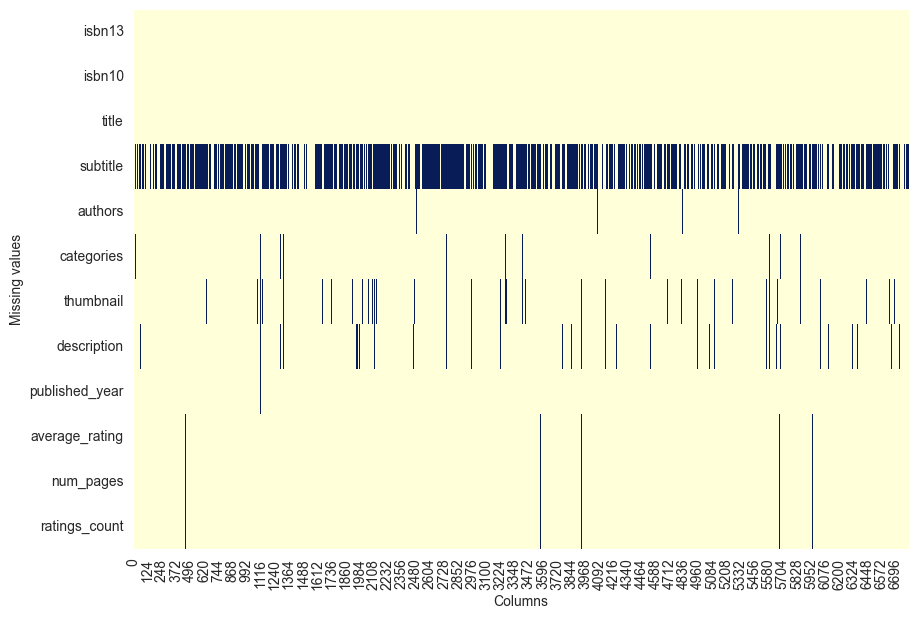

In [9]:
plt.figure(figsize=(10,7))

ax = plt.axes()
sns.heatmap(books.isna().transpose(), ax=ax, cbar=False, cmap="YlGnBu")
plt.xlabel('Columns')
plt.ylabel('Missing values')

You can see in there:
- **subtitle** is mostly missing so we can kind of write that variable off
- **categories, thumbnail, description** are mostly looking random
- **bottom variables (average_rating, num_pages, rating_count)**: the features imply that when one of variables are missed, remaining variables are missed too. Probably this dataset is from another dataset and that dataset didn't contain all the books in the bigger books. Books having missing values probably are new or have other characteristics (ex: high/low rating). This can make a bias in analysis step, because missing books which are dependent on their characters can not be random, which leads to research's results

In [10]:
books['missing_description'] = np.where(books['description'].isnull(), 1, 0)
books['age_of_books'] = 2025 - books['published_year']

In this, we use Spearman method to measure non-linear correlation and does not require  normally distributed data, while Pearson only measures linear correlation and assumes normally distributed data. With the columns like **missing_description** and **age_of_books**, Spearman (based on ranks) is more flexible, handling outlier data/ non-continuous values well.

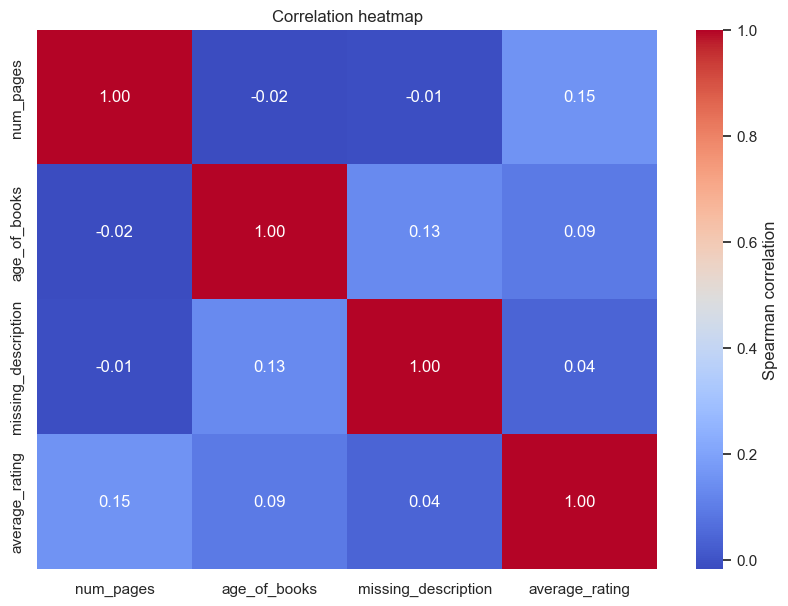

In [11]:
columns_of_interest = ['num_pages', 'age_of_books', 'missing_description', 'average_rating']

correlation_matrix = books[columns_of_interest].corr(method='spearman')

sns.set_theme(style="white")
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                      cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

Spearman correlation analysis shows that the relationships between variables such as **number of pages, age of books, missing descriptions, and average rating** are all weak (correlation values close to 0). This indicates that removing books with missing descriptions is unlikely to introduce significant bias into the recommender system, and our dataset remains fairly representative in terms of book length, age, and rating.

In [12]:
books[(books['description'].isnull()) |
      (books['num_pages'].isnull()) |
      (books['average_rating'].isnull()) |
      (books['published_year'].isnull())]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_books
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,1,25.0
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,1,23.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,1,47.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,1,72.0
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,1,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,1,23.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,1,19.0
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,0,18.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,1,32.0


You can look the resulting of the dataframe, this consists of 303 missing rows which are under 5% of our dataset. So we can definitely get rid of these observations and not be confused too much.

In [13]:
book_not_missing = books[~(books['description'].isnull()) &
                         ~(books['num_pages'].isnull()) &
                         ~(books['average_rating'].isnull()) &
                         ~(books['published_year'].isnull())]

In [14]:
book_not_missing.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_books
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0


### **4. Checking the number of categories**

In [15]:
book_not_missing['categories'].value_counts().reset_index().sort_values('count', ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
526,English essays,1
527,Inventions,1
528,Building laws,1
529,LITERARY CRITICISM,1


In [16]:
import plotly.express as px

category_counts = book_not_missing['categories'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

fig = px.bar(category_counts, x='Category', y='Count',
             title='Book Categories',
             labels={'Count': 'Number of Books', 'Category': 'Book Category'},
             hover_data=['Count'])

fig.update_layout(xaxis_tickangle=-45)
fig.show()

### **5. Remove short description**

In this step, we will check how long words in a description, if they are so short (just having 1-10 words), they can be not useful values so we can get rid of these.

In [17]:
book_not_missing['words_in_description'] = book_not_missing['description'].apply(lambda x: len(x.split()))
book_not_missing.head()

C:\Users\ngmin\AppData\Local\Temp\ipykernel_8176\4287378749.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_books,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45


In [21]:
book_not_missing.loc[book_not_missing['words_in_description'].between(1, 4), 'description'].head()

6                                 Donation.
11                           Fantasy-roman.
748    Includes bibliographical references.
770                   Bound For Oregon (PB)
775                      No Marketing Blurb
Name: description, dtype: object

In [22]:
book_not_missing.loc[book_not_missing['words_in_description'].between(5, 14), 'description'].head()

2     Volume Two of Stephen Donaldson's acclaimed se...
38    Koko is Peter Straub's foray into the psycholo...
70    A matter of life and death - and the Throne of...
77                       Nonsense rhyming story. 4 yrs+
84    A study guide for the novel There's a Boy in t...
Name: description, dtype: object

In [23]:
book_not_missing.loc[book_not_missing['words_in_description'].between(15, 24), 'description'].head()

10    One of Sidney Sheldon's most popular and bests...
32    Tells the story of three generations of Chines...
36    A magical and fantastic collection of early st...
57    A young drifter finds more than he bargained f...
68    A new 'The Doors of Perception' for the 21st c...
Name: description, dtype: object

Normally, with at least 30 words in a description can the information be conveyed effectively to the reader. So in this we will filter those values having at least 25 words in a description.

In [24]:
books_25_words_in_description = book_not_missing[book_not_missing['words_in_description'] >= 25]
books_25_words_in_description.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_books,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75


In [25]:
print("The shape of book dataset after removing short descriptions:", books_25_words_in_description.shape)

The shape of book dataset after removing short descriptions: (5197, 15)


### **6. Final cleaning step**

To enhance the descriptive quality of book titles for content-based recommendation, we combined the **title** and **subtitle** columns into a single field called **title_and_subtitle**. Since many entries in the subtitle column are missing, we only appended the subtitle to the title when it was present and non-empty. The combined format follows a natural structure like **"Title: Subtitle"**

In [29]:
raw = "  I love you so much  "
raw.strip()

'I love you so much'

In [30]:
# Function to combine title and subtitle (if subtitle is not a missing value)
def combine_title_subtitle(row):
    if pd.notna(row['subtitle']) and row['subtitle'].strip() != "":
        return f"{row['title']}: {row['subtitle']}"
    else:
        return row['title']

books_25_words_in_description['title_and_subtitle'] = books_25_words_in_description.apply(combine_title_subtitle, axis=1)

C:\Users\ngmin\AppData\Local\Temp\ipykernel_8176\813681490.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
books_25_words_in_description.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_books,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain


Next, we will merge the column **isbn13** and **description** to a new column called **tagged_description**. This column combines each book's unique identifier with its textual description. By doing so, we ensure that
every piece of descriptive content is directly associated with its corresponding book. This is particularly useful for downstream tasks such as vectorization and semantic search, where retaining a reference to the original source within the text can enhance traceability, retrieval accuracy, and model interpretability.

In [32]:
books_25_words_in_description['tagged_description'] = books_25_words_in_description[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)

C:\Users\ngmin\AppData\Local\Temp\ipykernel_8176\468495441.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
books_25_words_in_description['tagged_description'].head()

0    9780002005883 A NOVEL THAT READERS and critics...
1    9780002261982 A new 'Christie for Christmas' -...
3    9780006178736 A memorable, mesmerizing heroine...
4    9780006280897 Lewis' work on the nature of lov...
5    9780006280934 "In The Problem of Pain, C.S. Le...
Name: tagged_description, dtype: object

Finally, we will drop unnecessary columns for the building model step after and convert to a new file dataset as a clean file

In [35]:
books_25_words_in_description.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count', 'missing_description', 'age_of_books',
       'words_in_description', 'title_and_subtitle', 'tagged_description'],
      dtype='object')

In [36]:
books_25_words_in_description.drop(['subtitle', 'missing_description', 'age_of_books', 'words_in_description'], axis=1, inplace=True)

C:\Users\ngmin\AppData\Local\Temp\ipykernel_8176\1953801955.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
books_25_words_in_description.to_csv(r"D:\Workspace\LLM\Book Recommendation\dataset\books_cleaned.csv", index=False)